In [1]:
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from pprint import pprint
from sklearn.metrics import precision_recall_curve

In [3]:
df = yf.download("AAPL", start="2020-01-01", end="2024-01-01", interval='1d')

C:\Users\User PC\AppData\Local\Temp\ipykernel_800\2411600819.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-01-01", interval='1d')
[*********************100%***********************]  1 of 1 completed


In [5]:
df['SMA_20'] = ta.sma(df['Close'], length=20)
df['EMA_20'] = ta.ema(df['Close'], length=20)
df['RSI_14'] = ta.rsi(df['Close'], length=14)

In [7]:
df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns.values]

In [9]:
df = df.rename(columns={
    'Open_AAPL': 'Open',
    'High_AAPL': 'High',
    'Low_AAPL': 'Low',
    'Close_AAPL': 'Close',
    'Volume_AAPL': 'Volume'
})

In [11]:
df.ta.macd(append=True)
df['SMA_20'] = ta.sma(df['Close'], length=20)
df['EMA_20'] = ta.ema(df['Close'], length=20)
df['RSI_14'] = ta.rsi(df['Close'], length=14)

In [13]:
df = df.drop(columns=['SMA_20_', 'EMA_20_', 'RSI_14_'], errors='ignore')

In [15]:
print(df.head())

                Close       High        Low       Open     Volume  \
Date                                                                
2020-01-02  72.620842  72.681289  71.373218  71.627092  135480400   
2020-01-03  71.914833  72.676462  71.689973  71.847133  146322800   
2020-01-06  72.487839  72.526526  70.783241  71.034702  118387200   
2020-01-07  72.146927  72.753808  71.926900  72.497514  108872000   
2020-01-08  73.307518  73.609752  71.849540  71.849540  132079200   

            MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  SMA_20  EMA_20  RSI_14  
Date                                                                            
2020-01-02           NaN            NaN            NaN     NaN     NaN     NaN  
2020-01-03           NaN            NaN            NaN     NaN     NaN     NaN  
2020-01-06           NaN            NaN            NaN     NaN     NaN     NaN  
2020-01-07           NaN            NaN            NaN     NaN     NaN     NaN  
2020-01-08           NaN      

In [17]:
df = df.dropna()

In [19]:
print(df.index.duplicated().sum())  

0


In [21]:
print((df[['Close', 'Open', 'High', 'Low']] <= 0).sum())

Close    0
Open     0
High     0
Low      0
dtype: int64


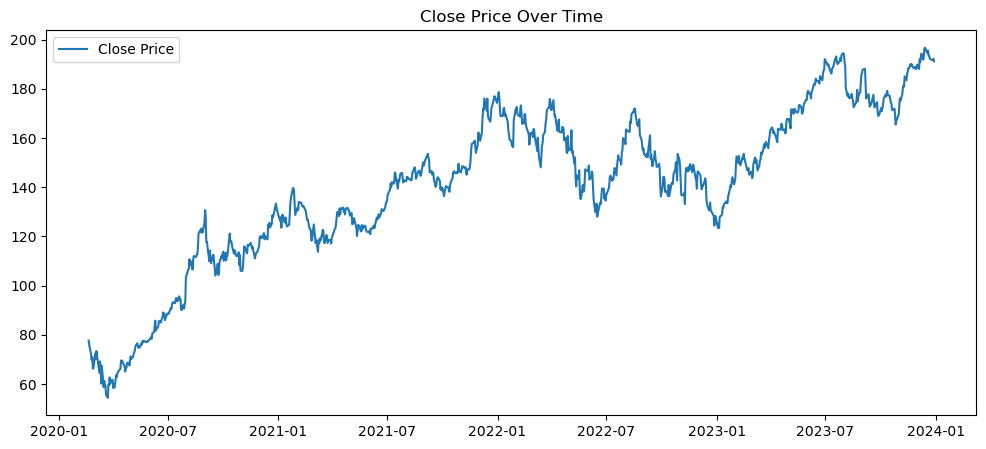

In [23]:
df = df.reset_index()  # This will move the index to a 'Date' column

plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.legend()
plt.show()

In [25]:
plt.figure(figsize=(12,3))
plt.plot(df['Date'], df['Volume'], label='Volume', color='orange')
plt.title('Volume Over Time')
plt.legend()
plt.show()

In [27]:
close_mean = df['Close'].mean()
close_std = df['Close'].std()
outliers = df[(df['Close'] > close_mean + 3*close_std) | (df['Close'] < close_mean - 3*close_std)]
print("Extreme close price outliers:\n", outliers)

Extreme close price outliers:
 Empty DataFrame
Columns: [Date, Close, High, Low, Open, Volume, MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9, SMA_20, EMA_20, RSI_14]
Index: []


In [29]:
date_range = pd.date_range(df['Date'].min(), df['Date'].max(), freq='B')  # 'B' = business day

missing_dates = set(date_range) - set(df['Date'])
print(f"Missing trading dates: {sorted(missing_dates)}")

Missing trading dates: [Timestamp('2020-04-10 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-07-03 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-18 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-04-02 00:00:00'), Timestamp('2021-05-31 00:00:00'), Timestamp('2021-07-05 00:00:00'), Timestamp('2021-09-06 00:00:00'), Timestamp('2021-11-25 00:00:00'), Timestamp('2021-12-24 00:00:00'), Timestamp('2022-01-17 00:00:00'), Timestamp('2022-02-21 00:00:00'), Timestamp('2022-04-15 00:00:00'), Timestamp('2022-05-30 00:00:00'), Timestamp('2022-06-20 00:00:00'), Timestamp('2022-07-04 00:00:00'), Timestamp('2022-09-05 00:00:00'), Timestamp('2022-11-24 00:00:00'), Timestamp('2022-12-26 00:00:00'), Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2023-04-07 00:00:00'), Timestamp('2023-05-29 00

In [31]:
print(df[df['Volume'] == 0])  # Days when no shares traded (should be rare for big stocks)

# Find extremely high volumes (e.g., over 3 standard deviations)
vol_mean = df['Volume'].mean()
vol_std = df['Volume'].std()
extreme_volume = df[df['Volume'] > vol_mean + 3*vol_std]
print("Extreme high volume days:\n", extreme_volume)

Empty DataFrame
Columns: [Date, Close, High, Low, Open, Volume, MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9, SMA_20, EMA_20, RSI_14]
Index: []
Extreme high volume days:
           Date       Close        High         Low        Open     Volume  \
5   2020-02-27   66.290642   69.315313   66.154920   68.127744  320605600   
6   2020-02-28   66.251846   67.475775   62.134132   62.349837  426510000   
7   2020-03-02   72.419952   73.057364   67.308555   68.413722  341397200   
8   2020-03-03   70.119949   73.677810   69.266833   73.597834  319475600   
12  2020-03-09   64.509285   67.398226   63.740997   63.922768  286744800   
13  2020-03-10   69.155342   69.421941   65.284834   67.167985  285290000   
15  2020-03-12   60.161324   65.437528   60.105582   62.029930  418474000   
16  2020-03-13   67.369141   67.841748   61.305263   64.199059  370732000   
17  2020-03-16   58.702312   62.790941   58.166693   58.639296  322423600   
18  2020-03-17   61.283455   62.434667   57.778910   59.98682

In [33]:
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           973 non-null    datetime64[ns]
 1   Close          973 non-null    float64       
 2   High           973 non-null    float64       
 3   Low            973 non-null    float64       
 4   Open           973 non-null    float64       
 5   Volume         973 non-null    int64         
 6   MACD_12_26_9   973 non-null    float64       
 7   MACDh_12_26_9  973 non-null    float64       
 8   MACDs_12_26_9  973 non-null    float64       
 9   SMA_20         973 non-null    float64       
 10  EMA_20         973 non-null    float64       
 11  RSI_14         973 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 91.3 KB
None
                                Date       Close        High         Low  \
count                        

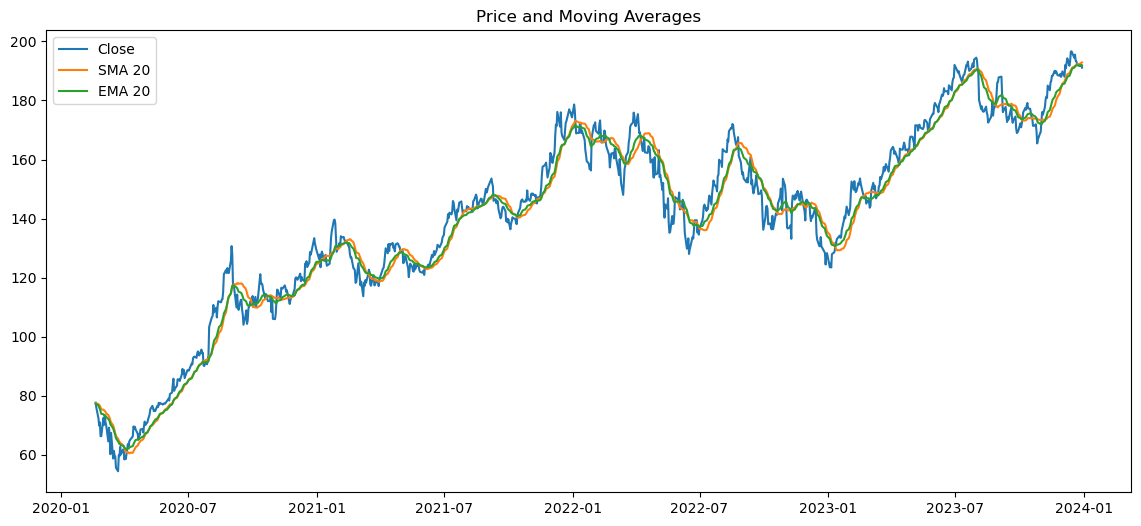

In [35]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['SMA_20'], label='SMA 20')
plt.plot(df['Date'], df['EMA_20'], label='EMA 20')
plt.legend()
plt.title('Price and Moving Averages')
plt.show()

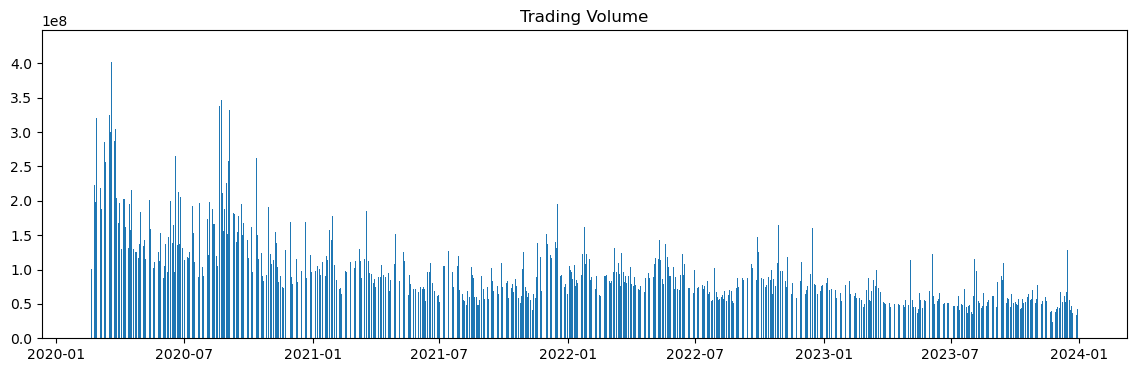

In [37]:
plt.figure(figsize=(14,4))
plt.bar(df['Date'], df['Volume'], label='Volume')
plt.title('Trading Volume')
plt.show()

In [38]:
plt.figure(figsize=(14,4))
plt.plot(df['Date'], df['RSI_14'], label='RSI 14')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI Over Time')
plt.legend()
plt.show()

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


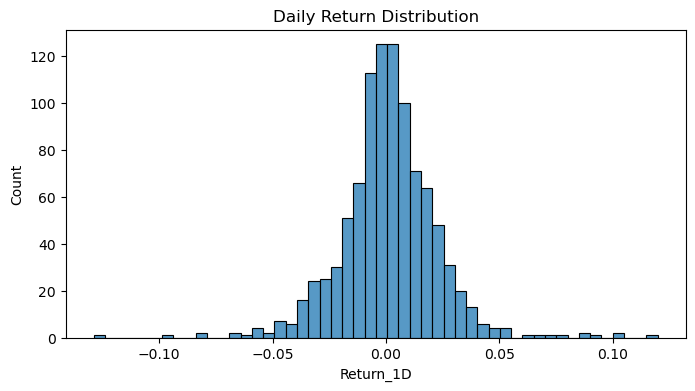

In [41]:
df['Return_1D'] = df['Close'].pct_change()
plt.figure(figsize=(8,4))
sns.histplot(df['Return_1D'].dropna(), bins=50)
plt.title('Daily Return Distribution')
plt.show()

In [43]:
print(df.dtypes)

Date             datetime64[ns]
Close                   float64
High                    float64
Low                     float64
Open                    float64
Volume                    int64
MACD_12_26_9            float64
MACDh_12_26_9           float64
MACDs_12_26_9           float64
SMA_20                  float64
EMA_20                  float64
RSI_14                  float64
Return_1D               float64
dtype: object


In [45]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [47]:
threshold = 0.001

In [49]:
df['Target'] = (df['Close'].shift(-1) - df['Close']) / df['Close']

In [51]:
conditions = [
    df['Target'] > threshold,
    df['Target'] < -threshold
]

In [53]:
choices = ['UP', 'DOWN']
df['Behavior'] = np.select(conditions, choices, default='SIDEWAYS')

In [55]:
df = df.dropna(subset=['Target'])

In [57]:
print(df['Behavior'].value_counts())
print(df[['Close', 'Target', 'Behavior']].tail())

Behavior
UP          485
DOWN        432
SIDEWAYS     55
Name: count, dtype: int64
          Close    Target  Behavior
967  193.264679 -0.005547      DOWN
968  192.192551 -0.002841      DOWN
969  191.646561  0.000518  SIDEWAYS
970  191.745804  0.002226        UP
971  192.172699 -0.005424      DOWN


In [59]:
from matplotlib.lines import Line2D

In [61]:
print(df.columns)
print(df.head())

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_20', 'EMA_20', 'RSI_14',
       'Return_1D', 'Target', 'Behavior'],
      dtype='object')
        Date      Close       High        Low       Open     Volume  \
0 2020-02-20  77.628288  78.682561  77.121754  78.192994  100566000   
1 2020-02-21  75.871170  77.664649  75.253152  77.221124  129554000   
2 2020-02-24  72.267265  73.721433  70.098137  72.044297  222195200   
3 2020-02-25  69.819435  73.321559  69.346835  72.938631  230673600   
4 2020-02-26  70.927002  72.194554  69.436482  69.443753  198054800   

   MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9     SMA_20     EMA_20  \
0      0.941356      -0.152768       1.094124  77.421349  77.252060   
1      0.717419      -0.301364       1.018783  77.355618  77.120547   
2      0.246303      -0.617984       0.864287  77.120814  76.658330   
3     -0.320881      -0.948134       0.627254  76.876774  76.007006   
4     -0.

In [63]:
print(df.isna().sum())

Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
MACD_12_26_9     0
MACDh_12_26_9    0
MACDs_12_26_9    0
SMA_20           0
EMA_20           0
RSI_14           0
Return_1D        1
Target           0
Behavior         0
dtype: int64


(972, 15)


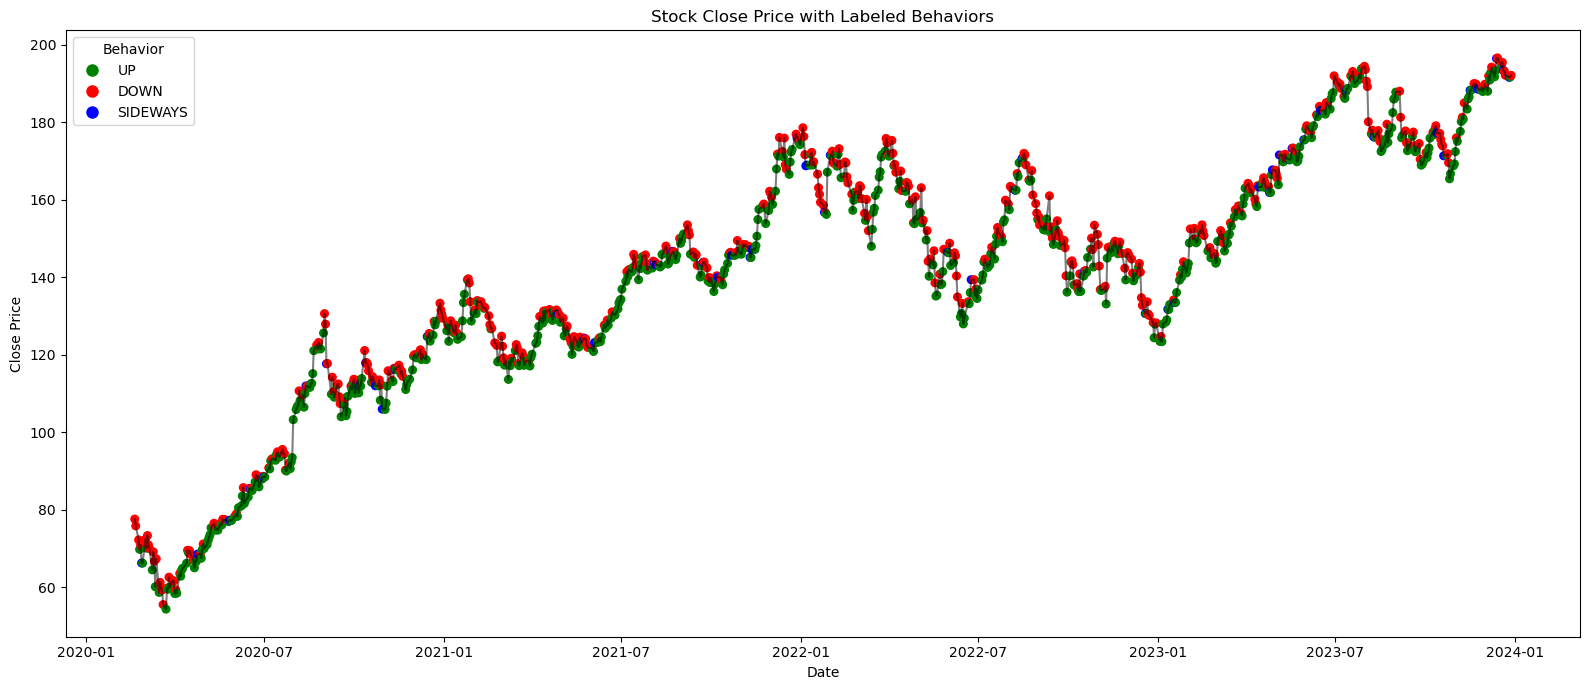

In [65]:
# Double-check DataFrame isn't empty
print(df.shape)

# Drop any rows with missing Close, Date, or Behavior just in case
df_plot = df.dropna(subset=['Date', 'Close', 'Behavior'])

# Map behavior to color
color_map = {'UP': 'green', 'DOWN': 'red', 'SIDEWAYS': 'blue'}
colors = df_plot['Behavior'].map(color_map)

plt.figure(figsize=(16, 7))
plt.plot(df_plot['Date'], df_plot['Close'], color='black', label='Close Price', alpha=0.5)
plt.scatter(df_plot['Date'], df_plot['Close'], c=colors, label='Behavior', s=30)

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='UP', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='DOWN', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='SIDEWAYS', markerfacecolor='blue', markersize=10),
]
plt.legend(handles=legend_elements, title='Behavior')

plt.title('Stock Close Price with Labeled Behaviors')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.tight_layout()
plt.show()

In [67]:
features = ['SMA_20', 'EMA_20', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'Return_1D']
X = df[features]
y = df['Behavior']

In [69]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [71]:
X = X.dropna()
y_encoded = y_encoded[X.index]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, shuffle=False  # maintain time order
)

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [79]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [81]:
plt.figure(figsize=(10,5))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [83]:
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")

Return_1D: 0.1565
RSI_14: 0.1526
MACDh_12_26_9: 0.1438
EMA_20: 0.1382
MACDs_12_26_9: 0.1369
MACD_12_26_9: 0.1365
SMA_20: 0.1354


In [85]:
y_pred = rf.predict(X_test)

In [87]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4307692307692308

Classification Report:
               precision    recall  f1-score   support

        DOWN       0.41      0.89      0.56        80
    SIDEWAYS       1.00      0.06      0.11        17
          UP       0.55      0.12      0.20        98

    accuracy                           0.43       195
   macro avg       0.65      0.36      0.29       195
weighted avg       0.53      0.43      0.34       195


Confusion Matrix:
 [[71  0  9]
 [15  1  1]
 [86  0 12]]


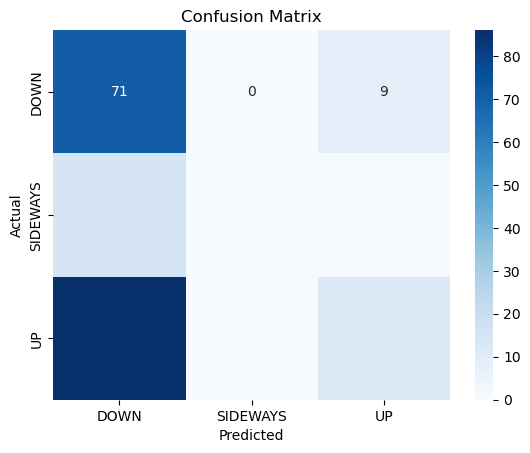

In [89]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [91]:
df_bin = df[df['Behavior'] != 'SIDEWAYS'].copy()
y_bin = le.fit_transform(df_bin['Behavior'])

In [93]:
X_bin = df_bin[features]

In [95]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bin, y_bin, test_size=0.2, shuffle=False)

In [97]:
df_bin = df[df['Behavior'] != 'SIDEWAYS'].copy()
df_bin['Behavior_num'] = le.fit_transform(df_bin['Behavior'])

In [99]:
features = ['SMA_20', 'EMA_20', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'Return_1D']

In [101]:
df_bin_clean = df_bin.dropna(subset=features + ['Behavior_num'])

In [103]:
X_bin = df_bin_clean[features]
y_bin = df_bin_clean['Behavior_num']

In [105]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bin, y_bin, test_size=0.2, shuffle=False)

In [107]:
rf_bin = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_bin.fit(Xb_train, yb_train)
y_bin_pred = rf_bin.predict(Xb_test)

In [109]:
print("Binary Accuracy:", accuracy_score(yb_test, y_bin_pred))
print(classification_report(yb_test, y_bin_pred, target_names=le.classes_[:2]))
print(confusion_matrix(yb_test, y_bin_pred))

Binary Accuracy: 0.45108695652173914
              precision    recall  f1-score   support

        DOWN       0.44      0.85      0.58        82
          UP       0.52      0.13      0.20       102

    accuracy                           0.45       184
   macro avg       0.48      0.49      0.39       184
weighted avg       0.48      0.45      0.37       184

[[70 12]
 [89 13]]


In [111]:
print("Training set class distribution:")
print(np.bincount(yb_train))

print("Test set class distribution:")
print(np.bincount(yb_test))

# If you want the labels (instead of just counts):
print("Label mapping (index: label):")
print({i: le.classes_[i] for i in range(len(le.classes_))})

Training set class distribution:
[349 383]
Test set class distribution:
[ 82 102]
Label mapping (index: label):
{0: 'DOWN', 1: 'UP'}


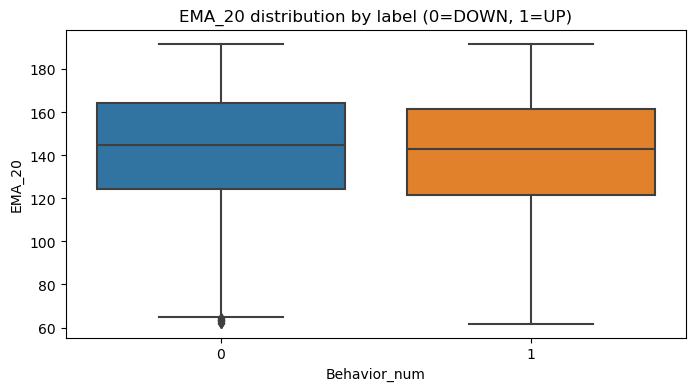

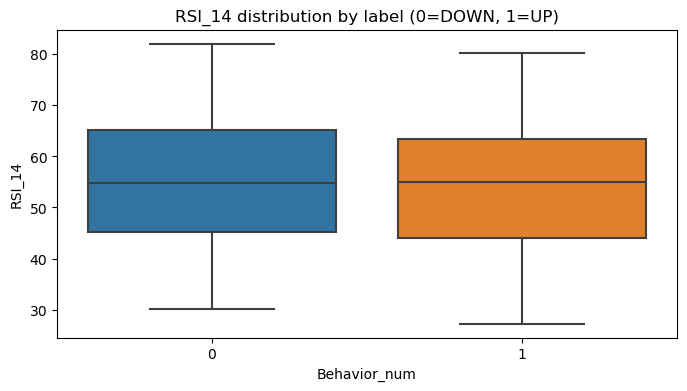

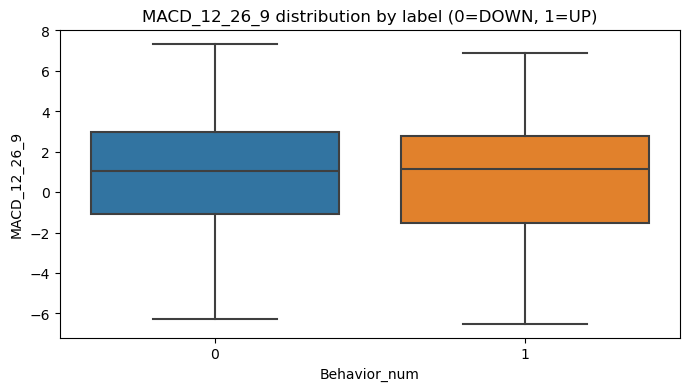

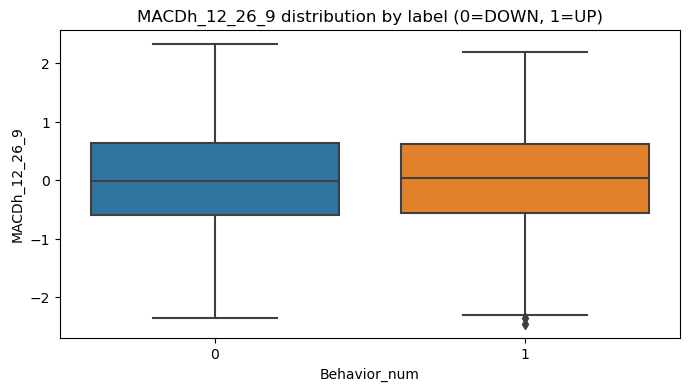

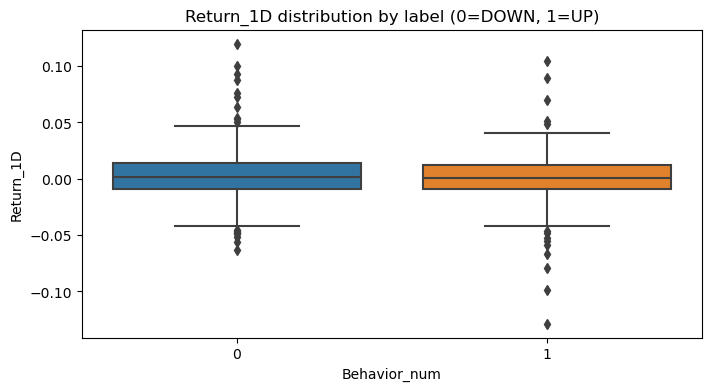

In [113]:
for feat in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df_bin_clean['Behavior_num'], y=df_bin_clean[feat])
    plt.title(f'{feat} distribution by label (0=DOWN, 1=UP)')
    plt.show()

In [115]:
df_bin_clean['Return_1D_lag1'] = df_bin_clean['Return_1D'].shift(1)
df_bin_clean['Return_1D_lag2'] = df_bin_clean['Return_1D'].shift(2)

C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\426911594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean['Return_1D_lag1'] = df_bin_clean['Return_1D'].shift(1)
C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\426911594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean['Return_1D_lag2'] = df_bin_clean['Return_1D'].shift(2)


In [119]:
df.ta.sma(length=20, append=True)
df.ta.ema(length=20, append=True)
df.ta.rsi(length=14, append=True)
df.ta.macd(append=True)
df.ta.atr(length=14, append=True)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
967    2.798741
968    2.771849
969    2.649024
970    2.630699
971    2.549867
Name: ATRr_14, Length: 972, dtype: float64

In [123]:
df_bin_clean.ta.bbands(length=20, std=2, append=True)

C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\2448531457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean.ta.bbands(length=20, std=2, append=True)
C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\2448531457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean.ta.bbands(length=20, std=2, append=True)
C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\2448531457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

BBL_20_2.0  BBM_20_2.0  BBU_20_2.0  BBB_20_2.0  BBP_20_2.0
1           NaN         NaN         NaN         NaN         NaN
2           NaN         NaN         NaN         NaN         NaN
3           NaN         NaN         NaN         NaN         NaN
4           NaN         NaN         NaN         NaN         NaN
6           NaN         NaN         NaN         NaN         NaN
..          ...         ...         ...         ...         ...
965  185.760555  191.368085  196.975616    5.860466    0.869163
967  186.134055  191.615771  197.097488    5.721571    0.650401
968  186.283284  191.722491  197.161697    5.674041    0.543210
970  186.526892  191.847077  197.167262    5.546277    0.490482
971  186.712711  191.959753  197.206794    5.466814    0.520292

[916 rows x 5 columns]

In [127]:
df_bin_clean.ta.obv(append=True)

C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\3524447956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean.ta.obv(append=True)


1      1.295540e+08
2     -9.264120e+07
3     -3.233148e+08
4     -1.252600e+08
6     -5.517700e+08
           ...     
965    2.133740e+09
967    2.087257e+09
968    2.050135e+09
970    2.002047e+09
971    2.036097e+09
Name: OBV, Length: 916, dtype: float64

In [129]:
ma20 = df_bin_clean['Close'].rolling(window=20).mean()
std20 = df_bin_clean['Close'].rolling(window=20).std()
df_bin_clean['BB_upper'] = ma20 + 2 * std20
df_bin_clean['BB_lower'] = ma20 - 2 * std20
df_bin_clean['BB_width'] = df_bin_clean['BB_upper'] - df_bin_clean['BB_lower']

C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\4042305159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean['BB_upper'] = ma20 + 2 * std20
C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\4042305159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean['BB_lower'] = ma20 - 2 * std20
C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\4042305159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [131]:
df_bin_clean['Volume_Change'] = df_bin_clean['Volume'].pct_change()

C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\2905227985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean['Volume_Change'] = df_bin_clean['Volume'].pct_change()


In [133]:
obv = [0]
for i in range(1, len(df_bin_clean)):
    if df_bin_clean['Close'].iloc[i] > df_bin_clean['Close'].iloc[i - 1]:
        obv.append(obv[-1] + df_bin_clean['Volume'].iloc[i])
    elif df_bin_clean['Close'].iloc[i] < df_bin_clean['Close'].iloc[i - 1]:
        obv.append(obv[-1] - df_bin_clean['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df_bin_clean['OBV'] = obv

C:\Users\User PC\AppData\Local\Temp\ipykernel_13356\3063113660.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin_clean['OBV'] = obv


In [135]:
df_bin_clean = df_bin_clean.dropna(subset=features + ['Behavior_num'])

In [137]:
X_bin = df_bin_clean[features]
y_bin = df_bin_clean['Behavior_num']

In [139]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bin, y_bin, test_size=0.2, shuffle=False
)

In [141]:
rf_bin = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_bin.fit(Xb_train, yb_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [143]:
print("Binary Accuracy:", accuracy_score(yb_test, y_bin_pred))
print(classification_report(yb_test, y_bin_pred, target_names=le.classes_[:2]))
print(confusion_matrix(yb_test, y_bin_pred))

Binary Accuracy: 0.45108695652173914
              precision    recall  f1-score   support

        DOWN       0.44      0.85      0.58        82
          UP       0.52      0.13      0.20       102

    accuracy                           0.45       184
   macro avg       0.48      0.49      0.39       184
weighted avg       0.48      0.45      0.37       184

[[70 12]
 [89 13]]


In [145]:
importances = rf_bin.feature_importances_
for feat, imp in zip(Xb_train.columns, importances):
    print(f"{feat}: {imp:.4f}")

SMA_20: 0.1296
EMA_20: 0.1395
RSI_14: 0.1582
MACD_12_26_9: 0.1308
MACDh_12_26_9: 0.1452
MACDs_12_26_9: 0.1372
Return_1D: 0.1595


In [147]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [149]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(Xb_train, yb_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [151]:
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_bin_pred = best_rf.predict(Xb_test)
print("Tuned Accuracy:", accuracy_score(yb_test, y_bin_pred))
print(classification_report(yb_test, y_bin_pred, target_names=le.classes_[:2]))

Best parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Tuned Accuracy: 0.4782608695652174
              precision    recall  f1-score   support

        DOWN       0.46      0.91      0.61        82
          UP       0.65      0.13      0.21       102

    accuracy                           0.48       184
   macro avg       0.55      0.52      0.41       184
weighted avg       0.56      0.48      0.39       184



In [153]:
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

In [155]:
cv_scores = cross_val_score(rf, X_bin, y_bin, cv=tscv)
print("TimeSeriesSplit CV scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

TimeSeriesSplit CV scores: [0.55263158 0.46052632 0.60526316 0.46710526 0.44078947]
Mean CV score: 0.5052631578947369


In [157]:
df_bin_clean = df_bin_clean.reset_index(drop=True)
X_bin = df_bin_clean[features]
y_bin = df_bin_clean['Behavior_num']

In [159]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bin, y_bin, test_size=0.2, shuffle=False)

In [161]:
results = Xb_test.copy()
results['Actual'] = yb_test
results['Predicted'] = y_bin_pred
results['Date'] = df_bin_clean.loc[Xb_test.index, 'Date'].values

In [163]:
# Mask for actual UPs that were predicted as DOWN
missed_ups = results[(results['Actual'] == 1) & (results['Predicted'] == 0)]
print("Number of UP days misclassified as DOWN:", len(missed_ups))
print(missed_ups.head())

Number of UP days misclassified as DOWN: 89
         SMA_20      EMA_20     RSI_14  MACD_12_26_9  MACDh_12_26_9  \
744  153.650452  154.293869  66.421028      3.115310       0.419527   
745  154.336130  155.126817  69.697157      3.429936       0.587322   
755  160.462726  159.981390  64.463547      2.991695      -0.091882   
758  161.612608  161.145475  58.616399      2.869894      -0.168263   
760  162.437202  161.466335  54.755521      2.190950      -0.539874   

     MACDs_12_26_9  Return_1D  Actual  Predicted       Date  
744       2.695783   0.009890       1          0 2023-03-30  
745       2.842614   0.015644       1          0 2023-03-31  
755       3.083578   0.007505       1          0 2023-04-18  
758       3.038157  -0.009781       1          0 2023-04-21  
760       2.730824  -0.000061       1          0 2023-04-26  


In [165]:
correct_ups = results[(results['Actual'] == 1) & (results['Predicted'] == 1)]

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


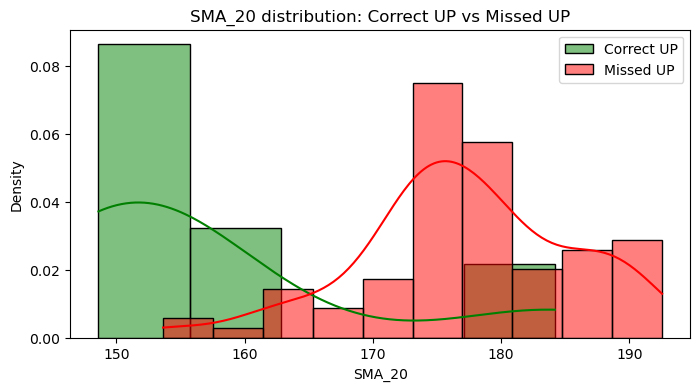

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


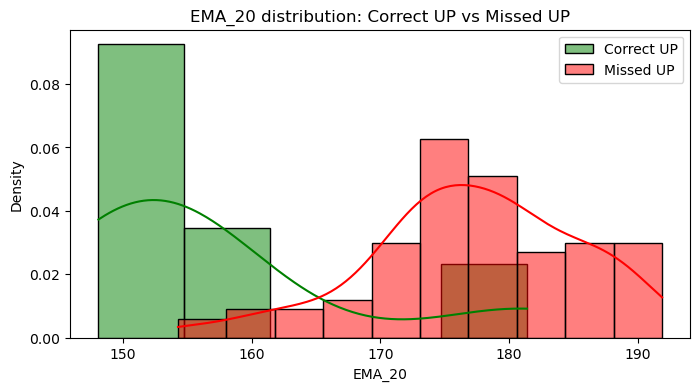

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


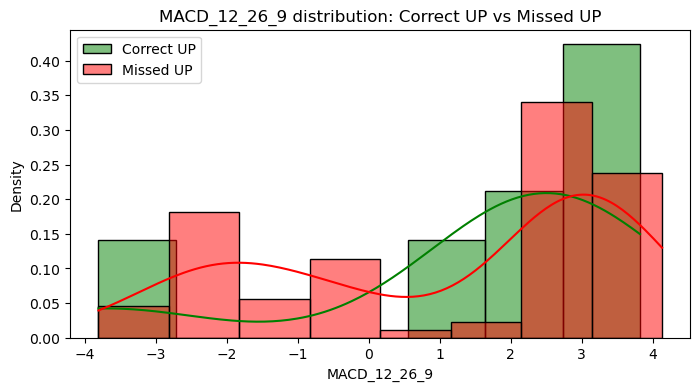

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


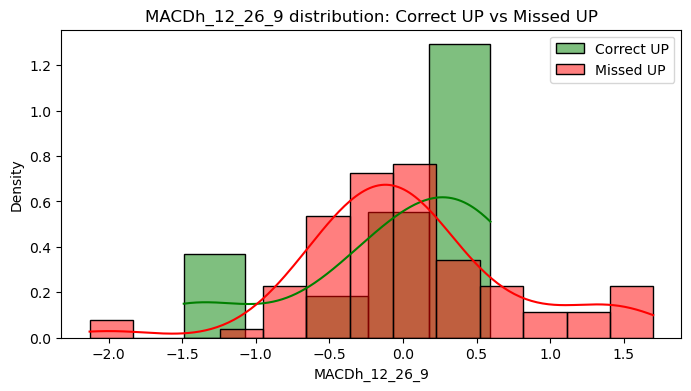

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


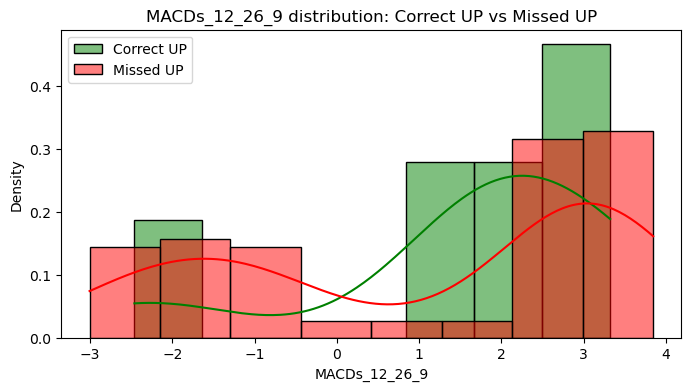

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


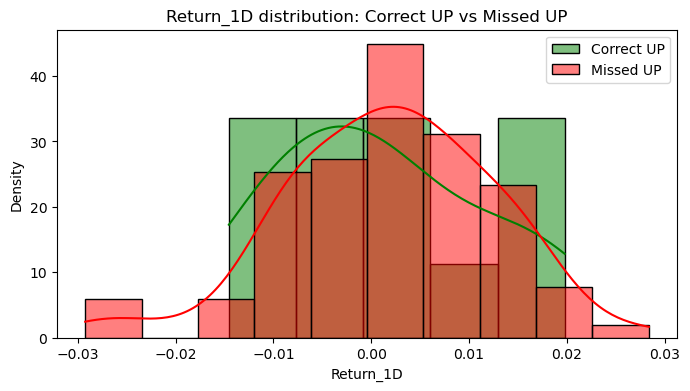

In [167]:
for feat in features:
    plt.figure(figsize=(8,4))
    sns.histplot(correct_ups[feat], color='green', label='Correct UP', kde=True, stat='density')
    sns.histplot(missed_ups[feat], color='red', label='Missed UP', kde=True, stat='density', alpha=0.5)
    plt.legend()
    plt.title(f"{feat} distribution: Correct UP vs Missed UP")
    plt.show()

In [169]:
print(missed_ups[['Date'] + features])

plt.figure(figsize=(16,7))
plt.plot(df_bin_clean['Date'], df_bin_clean['Close'], label='Close Price', color='black', alpha=0.7)
plt.scatter(missed_ups['Date'], df_bin_clean.loc[missed_ups.index, 'Close'], color='red', label='Missed UP', s=30)
plt.legend()
plt.title('Missed UP Predictions on Price Chart')
plt.show()

          Date      SMA_20      EMA_20     RSI_14  MACD_12_26_9  \
744 2023-03-30  153.650452  154.293869  66.421028      3.115310   
745 2023-03-31  154.336130  155.126817  69.697157      3.429936   
755 2023-04-18  160.462726  159.981390  64.463547      2.991695   
758 2023-04-21  161.612608  161.145475  58.616399      2.869894   
760 2023-04-26  162.437202  161.466335  54.755521      2.190950   
..         ...         ...         ...        ...           ...   
904 2023-12-07  188.210706  187.333303  67.949765      3.429607   
906 2023-12-11  189.219318  188.355581  62.184763      3.432874   
907 2023-12-12  189.711217  188.825954  64.777288      3.410172   
910 2023-12-18  191.432613  191.147068  62.680179      3.589651   
914 2023-12-27  192.558867  191.874473  53.354404      2.033374   

     MACDh_12_26_9  MACDs_12_26_9  Return_1D  
744       0.419527       2.695783   0.009890  
745       0.587322       2.842614   0.015644  
755      -0.091882       3.083578   0.007505  
758    

In [171]:
probs = best_rf.predict_proba(Xb_test)
results['Prob_UP'] = probs[:,1]
print(results[(results['Actual']==1) & (results['Predicted']==0)][['Prob_UP'] + features])

      Prob_UP      SMA_20      EMA_20     RSI_14  MACD_12_26_9  MACDh_12_26_9  \
744  0.491985  153.650452  154.293869  66.421028      3.115310       0.419527   
745  0.420420  154.336130  155.126817  69.697157      3.429936       0.587322   
755  0.487654  160.462726  159.981390  64.463547      2.991695      -0.091882   
758  0.463050  161.612608  161.145475  58.616399      2.869894      -0.168263   
760  0.467841  162.437202  161.466335  54.755521      2.190950      -0.539874   
..        ...         ...         ...        ...           ...            ...   
904  0.355470  188.210706  187.333303  67.949765      3.429607      -0.030880   
906  0.344006  189.219318  188.355581  62.184763      3.432874      -0.039063   
907  0.374316  189.711217  188.825954  64.777288      3.410172      -0.049412   
910  0.342754  191.432613  191.147068  62.680179      3.589651       0.005735   
914  0.373235  192.558867  191.874473  53.354404      2.033374      -0.817760   

     MACDs_12_26_9  Return_

In [173]:
results['Custom_Pred'] = (results['Prob_UP'] > 0.45).astype(int)

In [175]:
print(classification_report(results['Actual'], results['Custom_Pred'], target_names=le.classes_[:2]))

              precision    recall  f1-score   support

        DOWN       0.45      0.83      0.59        82
          UP       0.59      0.20      0.29       102

    accuracy                           0.48       184
   macro avg       0.52      0.51      0.44       184
weighted avg       0.53      0.48      0.42       184



In [177]:
probs = best_rf.predict_proba(Xb_test)[:, 1]  # Probability for UP

In [179]:
thresholds = np.arange(0.3, 0.61, 0.01)
best_f1 = 0
best_thresh = 0.5
best_report = None

In [181]:
for thresh in thresholds:
    custom_pred = (probs > thresh).astype(int)
    report = classification_report(yb_test, custom_pred, target_names=le.classes_[:2], output_dict=True)
    f1_up = report['UP']['f1-score']
    if f1_up > best_f1:
        best_f1 = f1_up
        best_thresh = thresh
        best_report = report

C:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarn

In [183]:
print(f"Best threshold for UP F1: {best_thresh:.2f}")
print(f"F1-score for UP: {best_f1:.3f}")
print("Detailed best classification report:")

Best threshold for UP F1: 0.30
F1-score for UP: 0.694
Detailed best classification report:


In [185]:
pprint(best_report)

{'DOWN': {'f1-score': 0.18,
          'precision': 0.5,
          'recall': 0.10975609756097561,
          'support': 82},
 'UP': {'f1-score': 0.6940298507462687,
        'precision': 0.5602409638554217,
        'recall': 0.9117647058823529,
        'support': 102},
 'accuracy': 0.5543478260869565,
 'macro avg': {'f1-score': 0.43701492537313436,
               'precision': 0.5301204819277108,
               'recall': 0.5107604017216643,
               'support': 184},
 'weighted avg': {'f1-score': 0.4649513303049968,
                  'precision': 0.5333944473546359,
                  'recall': 0.5543478260869565,
                  'support': 184}}


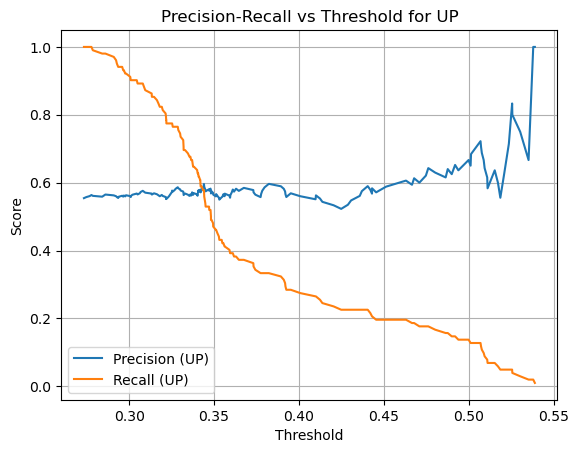

In [187]:
precision, recall, thresh = precision_recall_curve(yb_test, probs)
plt.plot(thresh, precision[:-1], label='Precision (UP)')
plt.plot(thresh, recall[:-1], label='Recall (UP)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold for UP')
plt.legend()
plt.grid()
plt.show()

In [189]:
thresholds = np.arange(0.30, 0.46, 0.01)

In [191]:
for thresh in thresholds:
    custom_pred = (probs > thresh).astype(int)
    report = classification_report(yb_test, custom_pred, target_names=le.classes_[:2], output_dict=True)
    up_recall = report['UP']['recall']
    up_precision = report['UP']['precision']
    down_recall = report['DOWN']['recall']
    accuracy = accuracy_score(yb_test, custom_pred)
    print(f"Threshold: {thresh:.2f} | UP Recall: {up_recall:.2f} | UP Precision: {up_precision:.2f} | DOWN Recall: {down_recall:.2f} | Accuracy: {accuracy:.2f}")

Threshold: 0.30 | UP Recall: 0.91 | UP Precision: 0.56 | DOWN Recall: 0.11 | Accuracy: 0.55
Threshold: 0.31 | UP Recall: 0.86 | UP Precision: 0.57 | DOWN Recall: 0.18 | Accuracy: 0.56
Threshold: 0.32 | UP Recall: 0.80 | UP Precision: 0.56 | DOWN Recall: 0.21 | Accuracy: 0.54
Threshold: 0.33 | UP Recall: 0.74 | UP Precision: 0.58 | DOWN Recall: 0.33 | Accuracy: 0.55
Threshold: 0.34 | UP Recall: 0.63 | UP Precision: 0.56 | DOWN Recall: 0.39 | Accuracy: 0.52
Threshold: 0.35 | UP Recall: 0.46 | UP Precision: 0.56 | DOWN Recall: 0.55 | Accuracy: 0.50
Threshold: 0.36 | UP Recall: 0.39 | UP Precision: 0.57 | DOWN Recall: 0.63 | Accuracy: 0.50
Threshold: 0.37 | UP Recall: 0.36 | UP Precision: 0.58 | DOWN Recall: 0.67 | Accuracy: 0.50
Threshold: 0.38 | UP Recall: 0.33 | UP Precision: 0.60 | DOWN Recall: 0.72 | Accuracy: 0.51
Threshold: 0.39 | UP Recall: 0.31 | UP Precision: 0.58 | DOWN Recall: 0.72 | Accuracy: 0.49
Threshold: 0.40 | UP Recall: 0.27 | UP Precision: 0.56 | DOWN Recall: 0.73 | Acc

In [193]:
#threshold 0.33 was selected for optimal balance, resulting in 74% recall and 58% precision for UP, with an overall accuracy of 55%.
custom_pred = (probs > 0.33).astype(int)

In [195]:
print(classification_report(yb_test, custom_pred, target_names=le.classes_[:2]))
print(confusion_matrix(yb_test, custom_pred))

              precision    recall  f1-score   support

        DOWN       0.50      0.33      0.40        82
          UP       0.58      0.74      0.65       102

    accuracy                           0.55       184
   macro avg       0.54      0.53      0.52       184
weighted avg       0.54      0.55      0.54       184

[[27 55]
 [27 75]]


In [197]:
results = Xb_test.copy()
results['Actual'] = yb_test.values
results['Predicted'] = custom_pred
results['Date'] = df_bin_clean.loc[Xb_test.index, 'Date'].values
results['Close'] = df_bin_clean.loc[Xb_test.index, 'Close'].values

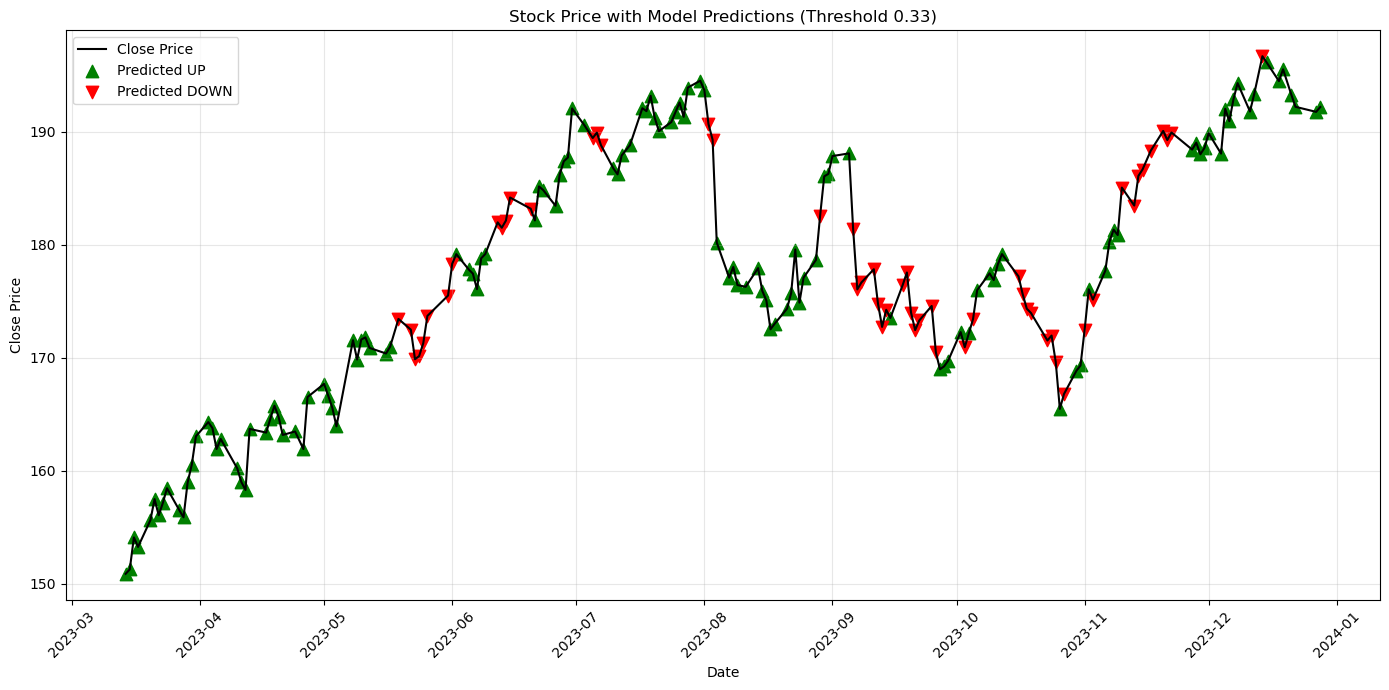

In [199]:
plt.figure(figsize=(14,7))
plt.plot(results['Date'], results['Close'], label='Close Price', color='black', linewidth=1.5)

# Plot UP predictions
plt.scatter(results['Date'][results['Predicted']==1], results['Close'][results['Predicted']==1], 
            label='Predicted UP', color='green', marker='^', s=80)

# Plot DOWN predictions
plt.scatter(results['Date'][results['Predicted']==0], results['Close'][results['Predicted']==0], 
            label='Predicted DOWN', color='red', marker='v', s=80)
plt.legend()
plt.title('Stock Price with Model Predictions (Threshold 0.33)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [201]:
def get_result_row(actual, pred):
    if actual == 1 and pred == 1:
        return 'True UP'
    elif actual == 0 and pred == 0:
        return 'True DOWN'
    elif actual == 0 and pred == 1:
        return 'False UP'
    elif actual == 1 and pred == 0:
        return 'Missed UP'
    else:
        return 'Other'

In [203]:
results['ResultType'] = [get_result_row(a, p) for a, p in zip(results['Actual'], results['Predicted'])]

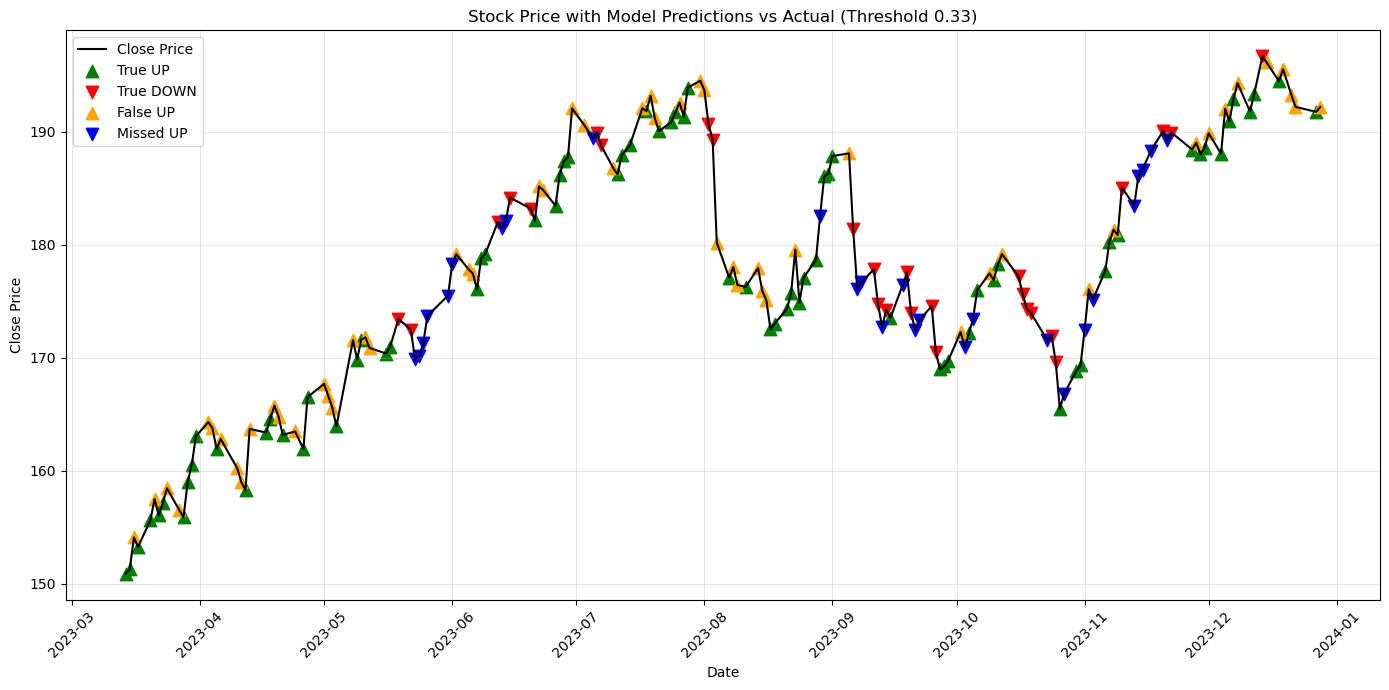

In [205]:
plt.figure(figsize=(14,7))
plt.plot(results['Date'], results['Close'], label='Close Price', color='black', linewidth=1.5)

# Plot True UP
plt.scatter(results['Date'][results['ResultType']=='True UP'],
            results['Close'][results['ResultType']=='True UP'],
            color='green', marker='^', s=80, label='True UP')

# Plot True DOWN
plt.scatter(results['Date'][results['ResultType']=='True DOWN'],
            results['Close'][results['ResultType']=='True DOWN'],
            color='red', marker='v', s=80, label='True DOWN')

# Plot False UP (Predicted UP, Actual DOWN)
plt.scatter(results['Date'][results['ResultType']=='False UP'],
            results['Close'][results['ResultType']=='False UP'],
            color='orange', marker='^', s=80, label='False UP')

# Plot Missed UP (Predicted DOWN, Actual UP)
plt.scatter(results['Date'][results['ResultType']=='Missed UP'],
            results['Close'][results['ResultType']=='Missed UP'],
            color='blue', marker='v', s=80, label='Missed UP')

plt.legend()
plt.title('Stock Price with Model Predictions vs Actual (Threshold 0.33)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

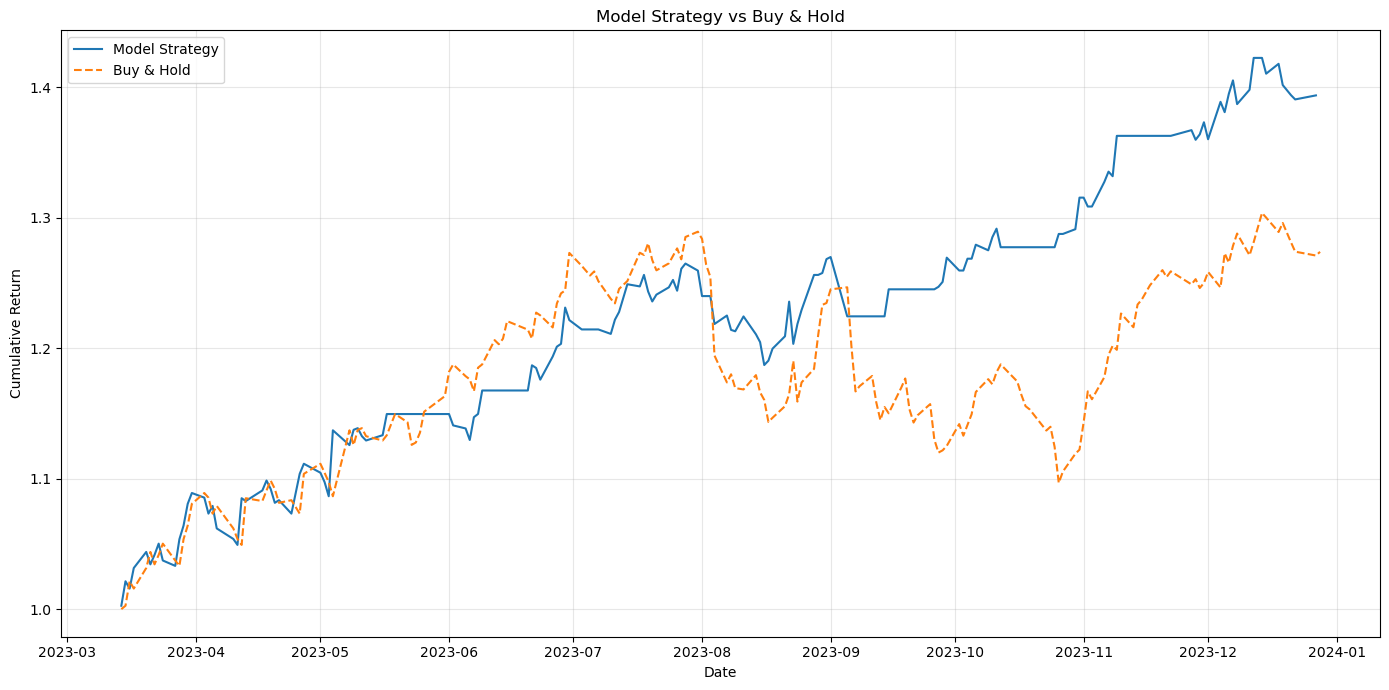

In [207]:
# Shift close price for next day return
results['Close_next'] = results['Close'].shift(-1)

# Calculate next day return if you "bought" on today's close
results['NextDayReturn'] = (results['Close_next'] - results['Close']) / results['Close']

# Only take return on days model predicted UP
results['StrategyReturn'] = np.where(results['Predicted']==1, results['NextDayReturn'], 0)

# Calculate cumulative return (start with 1, like RM1 or $1 capital)
results['CumulativeReturn'] = (1 + results['StrategyReturn']).cumprod()

# For comparison: "Buy & Hold" return (just hold stock throughout test period)
results['BuyHoldReturn'] = (results['Close'] / results['Close'].iloc[0])

# Plot both
plt.figure(figsize=(14,7))
plt.plot(results['Date'], results['CumulativeReturn'], label='Model Strategy')
plt.plot(results['Date'], results['BuyHoldReturn'], label='Buy & Hold', linestyle='--')
plt.legend()
plt.title('Model Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [209]:
latest_features = df_bin_clean[features].iloc[[-1]]

In [211]:
prob_up = best_rf.predict_proba(latest_features)[:,1][0]

In [213]:
if prob_up > 0.33:
    print(f"ðŸ“ˆ The model suggests **BUY** for {df_bin_clean['Date'].iloc[-1]}, with a {prob_up:.1%} probability the stock will go up tomorrow.")
else:
    print(f"ðŸ¤” The model suggests **HOLD** (do not buy) for {df_bin_clean['Date'].iloc[-1]}, with a {prob_up:.1%} probability the stock will go up tomorrow.")

ðŸ“ˆ The model suggests **BUY** for 2023-12-28 00:00:00, with a 35.1% probability the stock will go up tomorrow.
